# Histórico de desenvolvimento

Este notebook relata o desenvolvimento de um algoritmo que usa um autoencoder variacional treinado com imagens de cachorros para gerar novas imagens de cachorros a partir do espaço latente.

## Dependências

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil
import tensorflow as tf

from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import preprocess_input

Para reprodutibilidade:

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

## Dataset

O dataset sugerido para este exercício é o [Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification). Este notebook presume que os dados descompactados já estão presentes na pasta de trabalho.

Como a tarefa não propõe a análise de novas imagens, eu optei por não usar um dataset de validação, e utilizar todos os dados para treinamento.

Primeiro, vou colocar todos os arquivos em uma mesma pasta.

In [6]:
os.mkdir('train/train')
folders = ['train', 'test']
for folder in folders:
    files = os.listdir(folder)
    files = [f for f in files if '.jpg' in f]
    for f in files:
        shutil.move(folder + '/' + f, 'train/train/' + f)

In [7]:
print('O dataset contém', str(len(os.listdir('train/train'))), 'imagens.')

O dataset contém 20579 imagens.


### Pré-processamento

A tarefa de gerar novas imagens de cachorro vai ser mais fácil se o dataset de treinamento contiver imagens onde os cachorros podem ser vistos de forma mais clara.

Para filtrar fotos que supostamente atendam a esta prerrogativa, vou usar a rede ResNet50 para primeiro classificar as imagens disponíveis de acordo com as 1000 categorias do dataset ImageNet.

In [8]:
model = tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)

102973440/102967424 [==============================] - 1s 0us/step


In [9]:
datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
dataset = datagen.flow_from_directory('train', target_size = (244, 244), shuffle = False, batch_size = 32, class_mode = None)

Found 20579 images belonging to 1 classes.


In [10]:
preds = model.predict(dataset)

Agora eu posso conferir a frequência com que cada categoria foi identificada.

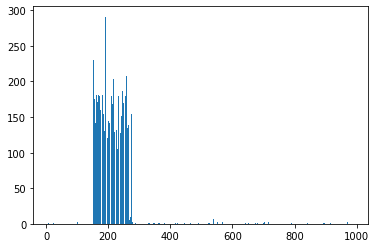

In [11]:
cats, counts = np.unique(np.argmax(preds, axis = 1), return_counts = True)
plt.bar(x = cats, height = counts);

As categorias mais frequentes estão concentradas na região entre o índice 150 e 265. De fato, de acordo com a [documentação](https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json), as raças de cachorro correspondem às categorias 151 a 268. Vou então criar uma máscara para apontar quais imagens do dataset foram identificadas cachorros.

In [12]:
mask_dogs = (np.argmax(preds, axis = 1) >= 151) & (np.argmax(preds, axis = 1) <= 268)
print(f'O dataset contém {mask_dogs.sum()} imagens classificadas como cachorros.')

O dataset contém 19892 imagens classificadas como cachorros.


Agora, dentre as imagens classificadas como cachorro, vou verificar qual a probabilidade que o modelo conferiu a estas classificações.

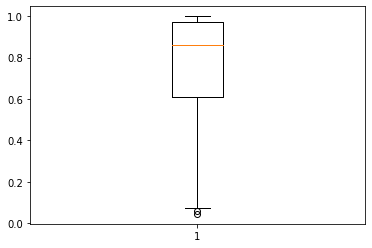

In [13]:
preds_dogs = preds.max(axis = 1)[mask_dogs]
plt.boxplot(preds_dogs);

A mediana é de aproximadamente 90%, mas a distribuição tem uma cauda longa à esquerda, com várias classificações não muito confiantes. Para filtrar as imagens com maior confiança, vou verificar primeiro quantas imagens classificadas como cachorro permanecem utilizando thresholds entre 50 e 100% de confiança.

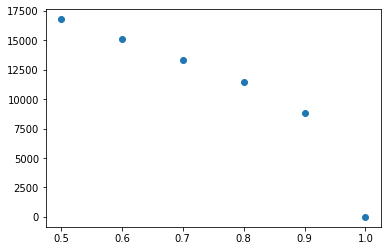

In [14]:
threshold = np.arange(0.5, 1.05, 0.1)
n_images = [np.sum(preds_dogs >= t) for t in threshold]
plt.scatter(threshold, n_images);

Se eu escolher 90% de confiança, permaneço com cerca de 8750 imagens, o que me parece um número razoável para treinar o algoritmo. Por isso, vou usar este threshold. 

Agora vou construir uma nova máscara para todas as classificações que atendem a este threshold, depois vou mesclar essa máscara com a anterior de forma a identificar as imagens classificadas como cachorro que passam por este segundo filtro.

In [15]:
mask_threshold = preds.max(axis = 1) >= 0.90
mask = mask_dogs & mask_threshold
print(f'O dataset contém {mask.sum()} imagens classificadas como cachorro com probabilidade maior ou igual a 90%.')

O dataset contém 8821 imagens classificadas como cachorro com probabilidade maior ou igual a 90%.


Vou então identificar quais são os arquivos que atendem a esses requisitos, movê-los para uma nova pasta, e apagar os arquivos e pastas que não vou mais usar.

In [16]:
files = np.array(dataset.filenames)[mask]
files = [f.split('/')[1] for f in files]

os.mkdir('train/dogs')

for f in files:
    shutil.move('train/train/' + f, 'train/dogs/' + f)

shutil.rmtree('train/train')

Finalmente, vou gerar um data generator para alimentar o modelo a partir das imagens em disco.

In [17]:
datagen = ImageDataGenerator(rescale = 1./255)
dataset_train = datagen.flow_from_directory('train', target_size = (244, 244), batch_size = 32, class_mode = 'input')

Found 8821 images belonging to 1 classes.


## Modelo

O modelo desenvolvido foi baseado em um [modelo disponibilizado na documentação da biblioteca Keras](https://keras.io/examples/generative/vae/).

Primeiro, eu defino uma classe que vai ser responsável por mapear os features visuais do encoder para um espaço latente com dimensões contínuas de distribuição normal, de média igual a 0 e desvio padrão igual a 1.

In [18]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape = (batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Na construção do encoder e do decoder, é preciso praticar um pouco de engenharia na definição, principalmente, do número de camadas de convolução, do número de filtros em cada camada, e do número de dimensões no espaço latente. Eu fiz vários testes, iniciando com um espaço latente de 25 dimensões e aumentando gradualmente, e utilizando 32 ou 64 filtros de convolução. Neste notebook, estou reportando a menor estrutura que produziu resultados minimamente interessantes.

In [19]:
latent_dim = 200
num_filters = 32

encoder_inputs = keras.Input(shape=(244, 244, 3))
x = layers.Conv2D(num_filters, 3, activation="relu", strides = 2, padding="same")(encoder_inputs)
x = layers.Conv2D(num_filters, 3, activation="relu", strides = 2, padding="same")(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 122, 122, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 61, 61, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 119072)       0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [20]:
conv_shape = encoder.layers[2].output_shape
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation="relu")(latent_inputs)
x = layers.Reshape(conv_shape[1:])(x)
x = layers.Conv2DTranspose(num_filters * 2, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(num_filters, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
dense (Dense)                (None, 119072)            23933472  
_________________________________________________________________
reshape (Reshape)            (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 122, 122, 64)      18496     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 244, 244, 32)      18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 244, 244, 3)       867       
Total params: 23,971,299
Trainable params: 23,971,299
Non-trainable params: 0
_______________________________________________

Agora eu defino o modelo, as métricas e o passo de treinamento.

Autoencoders variacionais usam uma métrica de custo mista, que soma tanto o custo na reconstrução da imagem a partir do estado latente, quanto as limitações impostas aos valores no estado latente, que devem manter a característica de continuidade e distribuição descrita acima.

In [21]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name = "total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name = "reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name = "kl_loss")

    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        return self.decoder(z)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            data, _ = data
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis = (1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Finalmente, compilo o modelo e defino callbacks par salvar checkpoints, reduzir a taxa de aprendizagem e parar o treinamento prematuramente se o desempenho estagnou.

In [22]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
callbacks = [EarlyStopping(patience = 20, verbose = 1, monitor = 'loss', mode = 'min', restore_best_weights = True),
             ModelCheckpoint('checkpoint.h5', monitor = 'loss', verbose = 1, save_weights_only = True, save_best_only = True),
             ReduceLROnPlateau(factor = 0.2, patience = 5, monitor = 'loss', mode = 'min')]

### Treinamento!

In [23]:
vae.fit(dataset_train, epochs = 100, callbacks = [callbacks])

Epoch 1/100
276/276 [==============================] - 46s 161ms/step - loss: 39102.3284 - reconstruction_loss: 37360.9219 - kl_loss: 166.7537

Epoch 00001: loss improved from inf to 37527.69531, saving model to /content/drive/MyDrive/checkpoint.h5
Epoch 2/100
276/276 [==============================] - 44s 161ms/step - loss: 35294.4075 - reconstruction_loss: 34874.4414 - kl_loss: 271.7578

Epoch 00002: loss improved from 37527.69531 to 35146.19922, saving model to /content/drive/MyDrive/checkpoint.h5
Epoch 3/100
276/276 [==============================] - 44s 160ms/step - loss: 34721.3491 - reconstruction_loss: 34318.6406 - kl_loss: 299.6913

Epoch 00003: loss improved from 35146.19922 to 34618.35547, saving model to /content/drive/MyDrive/checkpoint.h5
Epoch 4/100
276/276 [==============================] - 45s 161ms/step - loss: 34360.5495 - reconstruction_loss: 33976.8555 - kl_loss: 311.3484

Epoch 00004: loss improved from 34618.35547 to 34288.18359, saving model to /content/drive/My

### Avaliação

Vou fazer uma inspeção visual de algumas imagens após o processo de compactação e descompactação, comparando com as imagens originais.

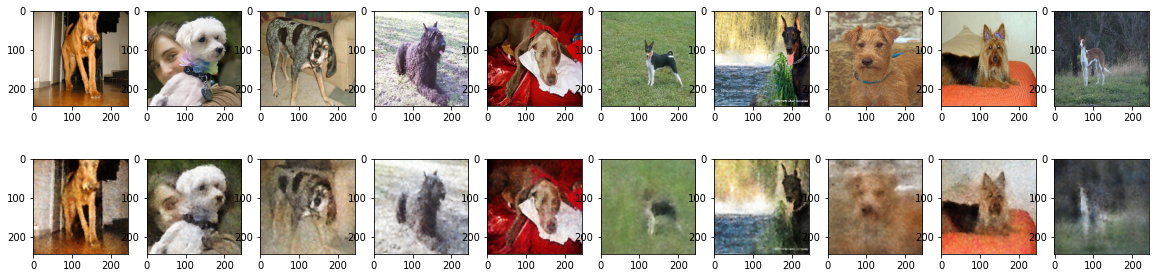

In [25]:
X, _ = dataset_train.next()
X = X[:10]
X_pred = vae.predict(X)
fig, ax = plt.subplots(2, 10, figsize = (20, 5))
for i, (x, x_pred) in enumerate(zip(X, X_pred)):
    ax[0, i].imshow(x)
    ax[1, i].imshow(x_pred)

O encoder e o decoder parecem ter sido treinados eficientemente.

Agora, vou verificar as distribuições dos valores de todas as imagens em todas as dimensões do espaço latente.

Média das médias: -0.007923647 Média dos desvios padrões: 0.97732604


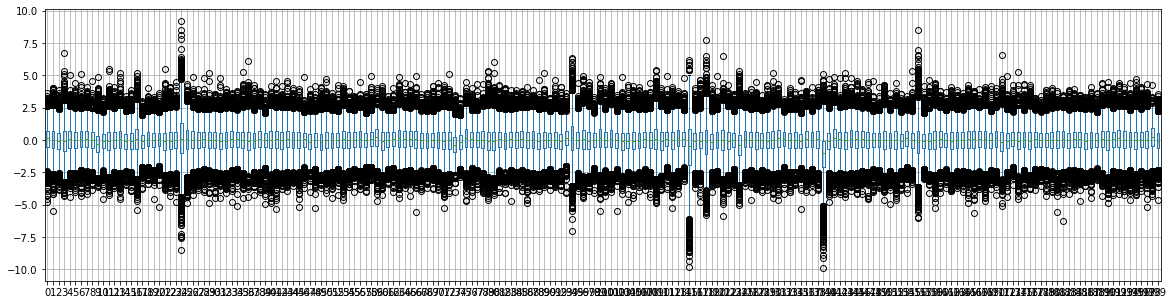

In [41]:
encoded = []
for i, (data, _) in enumerate(dataset_train):
    if i == len(dataset_train):
        break
    _, _, z = vae.encoder.predict(data)
    encoded.append(z)
encoded = np.concatenate(encoded, axis = 0)

plt.figure(figsize = (20, 5))
df = pd.DataFrame(encoded)
df.boxplot(column = df.columns.to_list());

encoded_mean = encoded.mean(axis = 0)
encoded_std = encoded.std(axis = 0)
print('Média das médias:', encoded_mean.mean(), 'Média dos desvios padrões:', encoded_std.mean())

Os valores estão de fato concentrados em torno de zero. A média das médias é praticamente 0 e a média dos desvios padrões é praticamente 1, como esperado.

## Geração de novas imagens

Para a geração de novas imagens, vou gerar valores aleatórios de uma distribuição normal com as mesmas características usadas no treinamento (média = 0, desvio padrão = 1) para todas as dimensões do espaço latente, e então usar o módulo decoder do modelo para decodifir a nova informação.

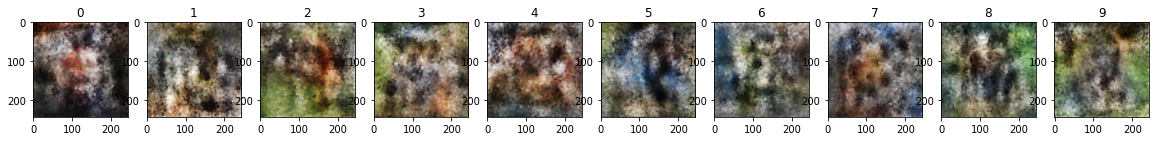

In [55]:
new_images_latent_space = np.random.normal(size = 10 * latent_dim).reshape(-1, latent_dim)
new_images = vae.decoder.predict(new_images_latent_space)
fig, ax = plt.subplots(1, 10, figsize = (20, 5))
for i, new_image in enumerate(new_images):
    ax[i].imshow(new_image)
    ax[i].set_title(i)

Com os parâmetros utilizados neste treinamento, é preciso um pouco de imaginação e liberdade poética para enxergar algum cachorro nas imagens, mas em algumas parece ser visível um focinho, os olhos, a cabeça, orelhas e a cor da pelagem.

## Sugestões de melhoria

Eu desconfio que o desempenho do modelo foi prejudicado porque, apesar do filtro utilizado para separar apenas as imagens mais claras, a composição das imagens ainda era muito heterogênea. Com maior homogeneidade de posicionamento dos animais, o modelo não acabaria codificando as informações do cenário, que parecem ter contaminado os resultados. Imagino que seria possível tratar o mesmo dataset com um detector para localizar e depois recortar somente a cabeça dos cachorros, por exemplo.

Outra coisa que poderia ajudar é adicionar mais camadas de convolução, que encontrariam outros níveis de abstração dos features visuais característicos dos animais, além de configurar as convoluções com mais filtros e outros tamanhos de kernel e stride.

Também me questionei se não usar um dataset de validação foi uma decisão acertada. A princípio eu penso que estou considerando como se este dataset representasse a população de interesse inteira, e eu estaria tentando gerar novos cachorros baseados nesta população, mas pode ser que isso tenha levado o modelo a "decorar" o dataset de treinamento e perder a capacidade de codificar as informações que estariam presentes "entre" os dados originais.

Ainda pensei que talvez fosse possível usar o modelo ResNet50 como um discriminador, inserindo-o na rede como um módulo de pesos fixos, que a cada passo de treinamento faria a classificação de dados aleatórios decodificados e poderia gerar um custo associado a classificações erradas de forma a forçar o autoencoder na direção de interesse.

## Próximos passos

Como próximos passos, se o melhor modelo fosse consideravelmente maior, eu tentaria compactar o módulo decoder do modelo, para poder utilizá-lo em um setup de produção com recursos computacionais limitados. A [documentação do Keras](https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras) ensina como fazer isso, sendo possível reduzir o modelo para cerca de 10% de seu tamanho original usando poda e quantização.

Por fim, eu desenvolveria um aplicativo com um botão "Gerar novo cachorro!". Quando acionado, ele geraria números aleatórios de uma distribuição normal, para cada uma das dimensões do espaço latente, passaria estes atributos ao modelo (que nesta etapa corresponde somente ao módulo decoder) que retornaria a imagem, e apresentaria ela ao usuário.